In [1]:
import numpy as np

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.layers import CuDNNLSTM as LSTM
from keras.layers import Dense, Input, Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
NUM_SAMPLES = 10000
MAX_VOCABULARY = 20000
MAX_SEQUENCE_LENGTH = 100
LATENT_DIM = 256
EMBEDDING_DIM = 100
BATCH_SIZE = 128

In [4]:
#Download the file from http://www.manythings.org/anki/
encoder_sentences = []
decoder_sentences_input = []
decoder_sentences_target = []
count = 0
lines = []
with open("spa.txt", encoding='utf-8') as f:
    for line in f:
        
        #Choose the first sentences in the file as they are the shortest ones, we do not want the larger ones
        #as to avoid memory issues
        if(count>=NUM_SAMPLES):
            break;
        encoder_sentence, decoder_sentence = line.split("\t");

        decoder_sentence_input = '<sos> ' + decoder_sentence
        decoder_sentence_target = decoder_sentence + ' <eos>'
        
        encoder_sentences.append(encoder_sentence)
        decoder_sentences_input.append(decoder_sentence_input)
        decoder_sentences_target.append(decoder_sentence_target)
        
        count += 1

In [5]:
#Do not filter ? ! that are common expressions in english.
encoder_tokenizer = Tokenizer(num_words = MAX_VOCABULARY, filters = '')
encoder_tokenizer.fit_on_texts(encoder_sentences)

#Do not filter ¿? !¡ that are common expressions in spanish. Only filter new line.
decoder_tokenizer = Tokenizer(num_words = MAX_VOCABULARY, filters = '\n')
decoder_tokenizer.fit_on_texts(decoder_sentences_input + decoder_sentences_target)

In [6]:
encoder_sequences = encoder_tokenizer.texts_to_sequences(encoder_sentences)
decoder_sequences_input = decoder_tokenizer.texts_to_sequences(decoder_sentences_input)
decoder_sequences_target = decoder_tokenizer.texts_to_sequences(decoder_sentences_target)

In [7]:
decoder_index2word = {idx: word for word, idx in decoder_tokenizer.word_index.items()}


In [8]:
max_encoder_length = np.max([len(sentence) for sentence in encoder_sequences])
max_decoder_length = np.max([len(sentence) for sentence in decoder_sequences_input])

#Lets choose the minimum of these to save memory
MAX_DECODER_LENGTH = min(MAX_SEQUENCE_LENGTH, max_decoder_length)
MAX_ENCODER_LENGTH = min(MAX_SEQUENCE_LENGTH, max_encoder_length)
#We add one to the max_spanish and english words. This is because indexing with tokenizer starts at 1.
MAX_DECODER_WORDS = min(MAX_VOCABULARY, len(decoder_tokenizer.word_index) + 1) 
MAX_ENCODER_WORDS = min(MAX_VOCABULARY, len(encoder_tokenizer.word_index) + 1)

In [9]:
#Use post padding as we need the <sos> at the beggining of the sentences in the decoder (not necessary to do so in the encoder)
encoder_sequences_padded = pad_sequences(encoder_sequences, maxlen = MAX_ENCODER_LENGTH, padding='post')
decoder_sequences_input_padded = pad_sequences(decoder_sequences_input, maxlen = MAX_DECODER_LENGTH, padding = "post")
decoder_sequences_target_padded = pad_sequences(decoder_sequences_target, maxlen = MAX_DECODER_LENGTH, padding = "post")

In [10]:
#100 vector dimension.
word2vec = {}
with open("../basic_language_models/large_files/glove.6B/glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        tokens = line.split();
        word = tokens[0];
        vector = np.array(tokens[1:])
        word2vec[word] = vector;

In [11]:
#We can initialize the Embedding layer for the encoder block because we have teh pretrained weights for the encoder vocabulary.
#However, we do not have the spanish ones.

encoder_embeddings_weights = np.zeros((MAX_ENCODER_WORDS, EMBEDDING_DIM))

for word, index in encoder_tokenizer.word_index.items():
    if index < MAX_ENCODER_WORDS:
        if(word in word2vec):
            encoder_embeddings_weights[index] = word2vec[word]
    

In [12]:
len(decoder_sequences_target_padded), MAX_DECODER_LENGTH, MAX_DECODER_WORDS

(10000, 9, 6295)

In [13]:
decoder_targets = np.zeros((len(decoder_sequences_target_padded), MAX_DECODER_LENGTH, MAX_DECODER_WORDS))
for sentence_idx, sentence in enumerate(decoder_sequences_target_padded):
    for word_idx, word_id in enumerate(sentence):
        decoder_targets[sentence_idx, word_idx, word_id] = 1

In [14]:
encoder_embeddings = Embedding(MAX_ENCODER_WORDS, 
                               EMBEDDING_DIM, 
                               weights = [encoder_embeddings_weights], 
                               input_length=MAX_SEQUENCE_LENGTH)

#IF we had the pretrained weights for the spanish vocabulary we could use it here as well.
#Do not fix the input_length as it will be variable when we generate new sentences after training.
decoder_embeddings = Embedding(MAX_DECODER_WORDS,
                               EMBEDDING_DIM)



In [15]:
#Encoder
encoder_input = Input([MAX_ENCODER_LENGTH,])
embedded_input = encoder_embeddings(encoder_input)
encoder_lstm = LSTM(LATENT_DIM, return_state = True) #We don't need the outputs of the encoder
__, h_encoder, c_encoder = encoder_lstm(embedded_input)


def foo(module, x): pass <unknown> exec 1024
def foo(module, x): pass <unknown> exec 1024


In [16]:
#Decoder

#We use the decoder_input for teaching.
decoder_input = Input([MAX_DECODER_LENGTH,])
embedded_decoder_input = decoder_embeddings(decoder_input) #(batch_size, max_sequence_length, embedding_size)
decoder_lstm = LSTM(LATENT_DIM, return_state = True, return_sequences = True)
decoder_output, h_decoder, c_decoder = decoder_lstm(embedded_decoder_input, initial_state = [h_encoder, c_encoder])
dense = Dense(MAX_DECODER_WORDS, activation = 'softmax')
output = dense(decoder_output)

model = Model(inputs = [encoder_input, decoder_input], outputs = output)


In [17]:
model.compile(optimizer = Adam(), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [18]:
#I don't use a validation set as I want to resemble the input as much as possible. I'm only interesed in the 
#training loss and accuracy.
r = model.fit(x = [encoder_sequences_padded, decoder_sequences_input_padded], 
          y = decoder_targets, 
          epochs = 100, 
          batch_size= BATCH_SIZE)

Epoch 1/100
10000/10000 [==============================] - 36s 4ms/step - loss: 3.7078 - acc: 0.5780
Epoch 2/100
10000/10000 [==============================] - 33s 3ms/step - loss: 2.4288 - acc: 0.6603
Epoch 3/100
10000/10000 [==============================] - 33s 3ms/step - loss: 2.2032 - acc: 0.6955
Epoch 4/100
10000/10000 [==============================] - 33s 3ms/step - loss: 2.0610 - acc: 0.7024
Epoch 5/100
10000/10000 [==============================] - 34s 3ms/step - loss: 1.9460 - acc: 0.7116
Epoch 6/100
10000/10000 [==============================] - 34s 3ms/step - loss: 1.8491 - acc: 0.7185
Epoch 7/100
10000/10000 [==============================] - 33s 3ms/step - loss: 1.7645 - acc: 0.7259
Epoch 8/100
10000/10000 [==============================] - 33s 3ms/step - loss: 1.6857 - acc: 0.7355
Epoch 9/100
10000/10000 [==============================] - 34s 3ms/step - loss: 1.6148 - acc: 0.7408
Epoch 10/100
10000/10000 [==============================] - 33s 3ms/step - loss: 1.5442 - a

10000/10000 [==============================] - 33s 3ms/step - loss: 0.1016 - acc: 0.9581
Epoch 82/100
10000/10000 [==============================] - 33s 3ms/step - loss: 0.1015 - acc: 0.9585
Epoch 83/100
10000/10000 [==============================] - 33s 3ms/step - loss: 0.0989 - acc: 0.9587
Epoch 84/100
10000/10000 [==============================] - 33s 3ms/step - loss: 0.0962 - acc: 0.9586
Epoch 85/100
10000/10000 [==============================] - 33s 3ms/step - loss: 0.0960 - acc: 0.9587
Epoch 86/100
10000/10000 [==============================] - 33s 3ms/step - loss: 0.0954 - acc: 0.9582
Epoch 87/100
10000/10000 [==============================] - 33s 3ms/step - loss: 0.0938 - acc: 0.9592
Epoch 88/100
10000/10000 [==============================] - 34s 3ms/step - loss: 0.0937 - acc: 0.9584
Epoch 89/100
10000/10000 [==============================] - 33s 3ms/step - loss: 0.0911 - acc: 0.9591
Epoch 90/100
10000/10000 [==============================] - 33s 3ms/step - loss: 0.0906 - acc: 

In [19]:
model.save_weights("./seq2seq_traductor.h5")

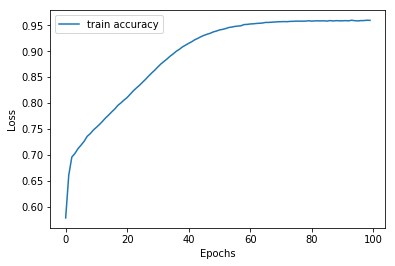

In [21]:
import matplotlib.pyplot as plt
plt.plot(r.history['acc'], label = 'train accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

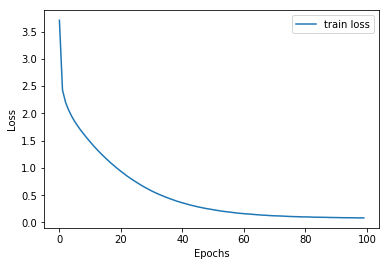

In [22]:
plt.plot(r.history['loss'], label = 'train loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
#During prediction, use the decoder to output the hidden state.
encoder_prediction_model = Model(inputs = [encoder_input], outputs = [h_encoder, c_encoder])

In [24]:
#Once we get the hidden state, pass it to the decoder that along the decoder input will output word indexes.
input_decoder2 = Input([1, ])
input_h = Input([LATENT_DIM, ])
input_c = Input([LATENT_DIM, ])
embedded_decoder_input2 = decoder_embeddings(input_decoder2)
o2, h2, c2 = decoder_lstm(embedded_decoder_input2, initial_state=[input_h, input_c])
outputs2 = dense(o2)
decoder_prediction_model = Model(inputs = [input_decoder2, input_h, input_c], outputs = [outputs2, h2, c2])

In [45]:
#Sample sentence.
def sample_sentence(encoder_sentence):
    encoder_sequence = encoder_tokenizer.texts_to_sequences([encoder_sentence])
    encoder_sequence_padded = pad_sequences(encoder_sequence, maxlen = MAX_ENCODER_LENGTH, padding = "post")
    h_s, c_s = encoder_prediction_model.predict(np.array(encoder_sequence_padded))
    decoder_input_init = np.array([[decoder_tokenizer.word_index['<sos>']]])
    
    decoder_input_ = decoder_input_init
    decoder_sentence = []
    #Use a loop to feed the decoder input with the last decoder output.
    for i in range(MAX_SEQUENCE_LENGTH):
        probs, h_s, c_s = decoder_prediction_model.predict([decoder_input_, h_s, c_s])
        #Do not take into account the first column.
        word_idx = np.argmax(probs[0, 0, 1:]) + 1
        word = decoder_index2word[word_idx]
        #If end of sentence token, break;
        if word == '<eos>':
            break;
        
        decoder_input_[0, 0] = word_idx;
        decoder_sentence.append(word)
    return ' '.join(decoder_sentence);

In [47]:
n_examples = 10
for i in range(n_examples):
    sample_index = np.random.choice(len(encoder_sentences));
    print("English sentence:", encoder_sentences[sample_index], 
          "\nSpanish translation:", sample_sentence(encoder_sentences[sample_index]))
    print()

English sentence: It was fabulous. 
Spanish translation: estaba fabuloso.

English sentence: Call me. 
Spanish translation: llamadme.

English sentence: Are you mad? 
Spanish translation: ¿estás loco?

English sentence: What's the plan? 
Spanish translation: ¿cuál es el plan?

English sentence: I need answers. 
Spanish translation: necesito respuestas.

English sentence: Are you crazy? 
Spanish translation: ¿estás loco?

English sentence: I am better. 
Spanish translation: estoy mejor.

English sentence: Don't stop. 
Spanish translation: no pares.

English sentence: I'm too drunk. 
Spanish translation: estoy demasiado borracho.

English sentence: Can I pay later? 
Spanish translation: puedo pagar más tarde?

